In [3]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import pickle
import random
from featurewiz import FeatureWiz

In [4]:
df = pd.read_csv('diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.shape

(101766, 50)

In [6]:
df.duplicated().any()

False

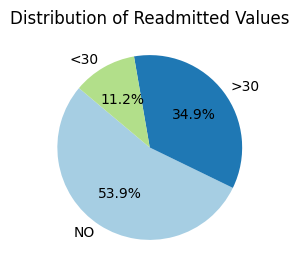

In [7]:
counts = df['readmitted'].value_counts(normalize=True)

plt.figure(figsize=(5, 3))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Readmitted Values')
plt.show()


The data is unbalanced meaning it will be harder to build a classifier, In aadition the relevant evaluation metric should be chosen.

I will train several models on the unbalanced data and on balanced data with or without feature selection

In [8]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [9]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

In [10]:
# List of object columns
object_columns = df.select_dtypes(include=['object']).columns.tolist()

# List of integer columns
int_columns = df.select_dtypes(include=['int']).columns.tolist()

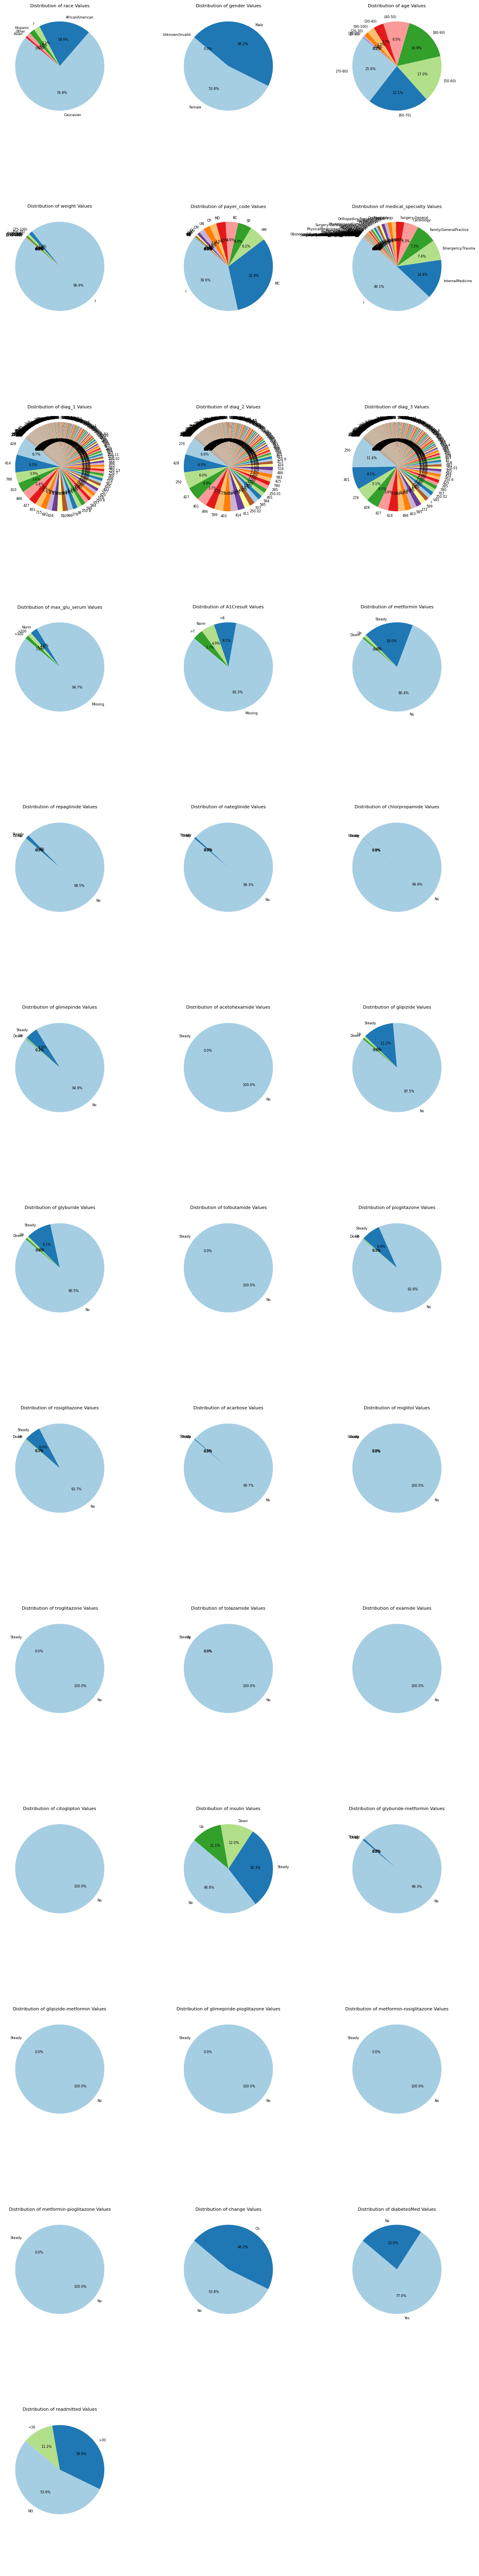

In [11]:
n_cols = len(object_columns)
n_rows = -(-n_cols // 3) 

fig, axes = plt.subplots(n_rows, 3, figsize=(12, 5 * n_rows))

axes = axes.ravel()

for idx, col in enumerate(object_columns):
    column_data = df[col].fillna('Missing')
    counts = column_data.value_counts(normalize=True)
    
    axes[idx].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, textprops={'fontsize': 6})
    axes[idx].set_title(f'Distribution of {col} Values', fontsize=8)

for j in range(idx+1, n_rows*3):
    axes[j].axis('off')

plt.tight_layout()  
plt.show()


There are several columns with only one value and many colums that refer to specific medications such as glipizide or miglitolthat that are positive to very minor part of the patients

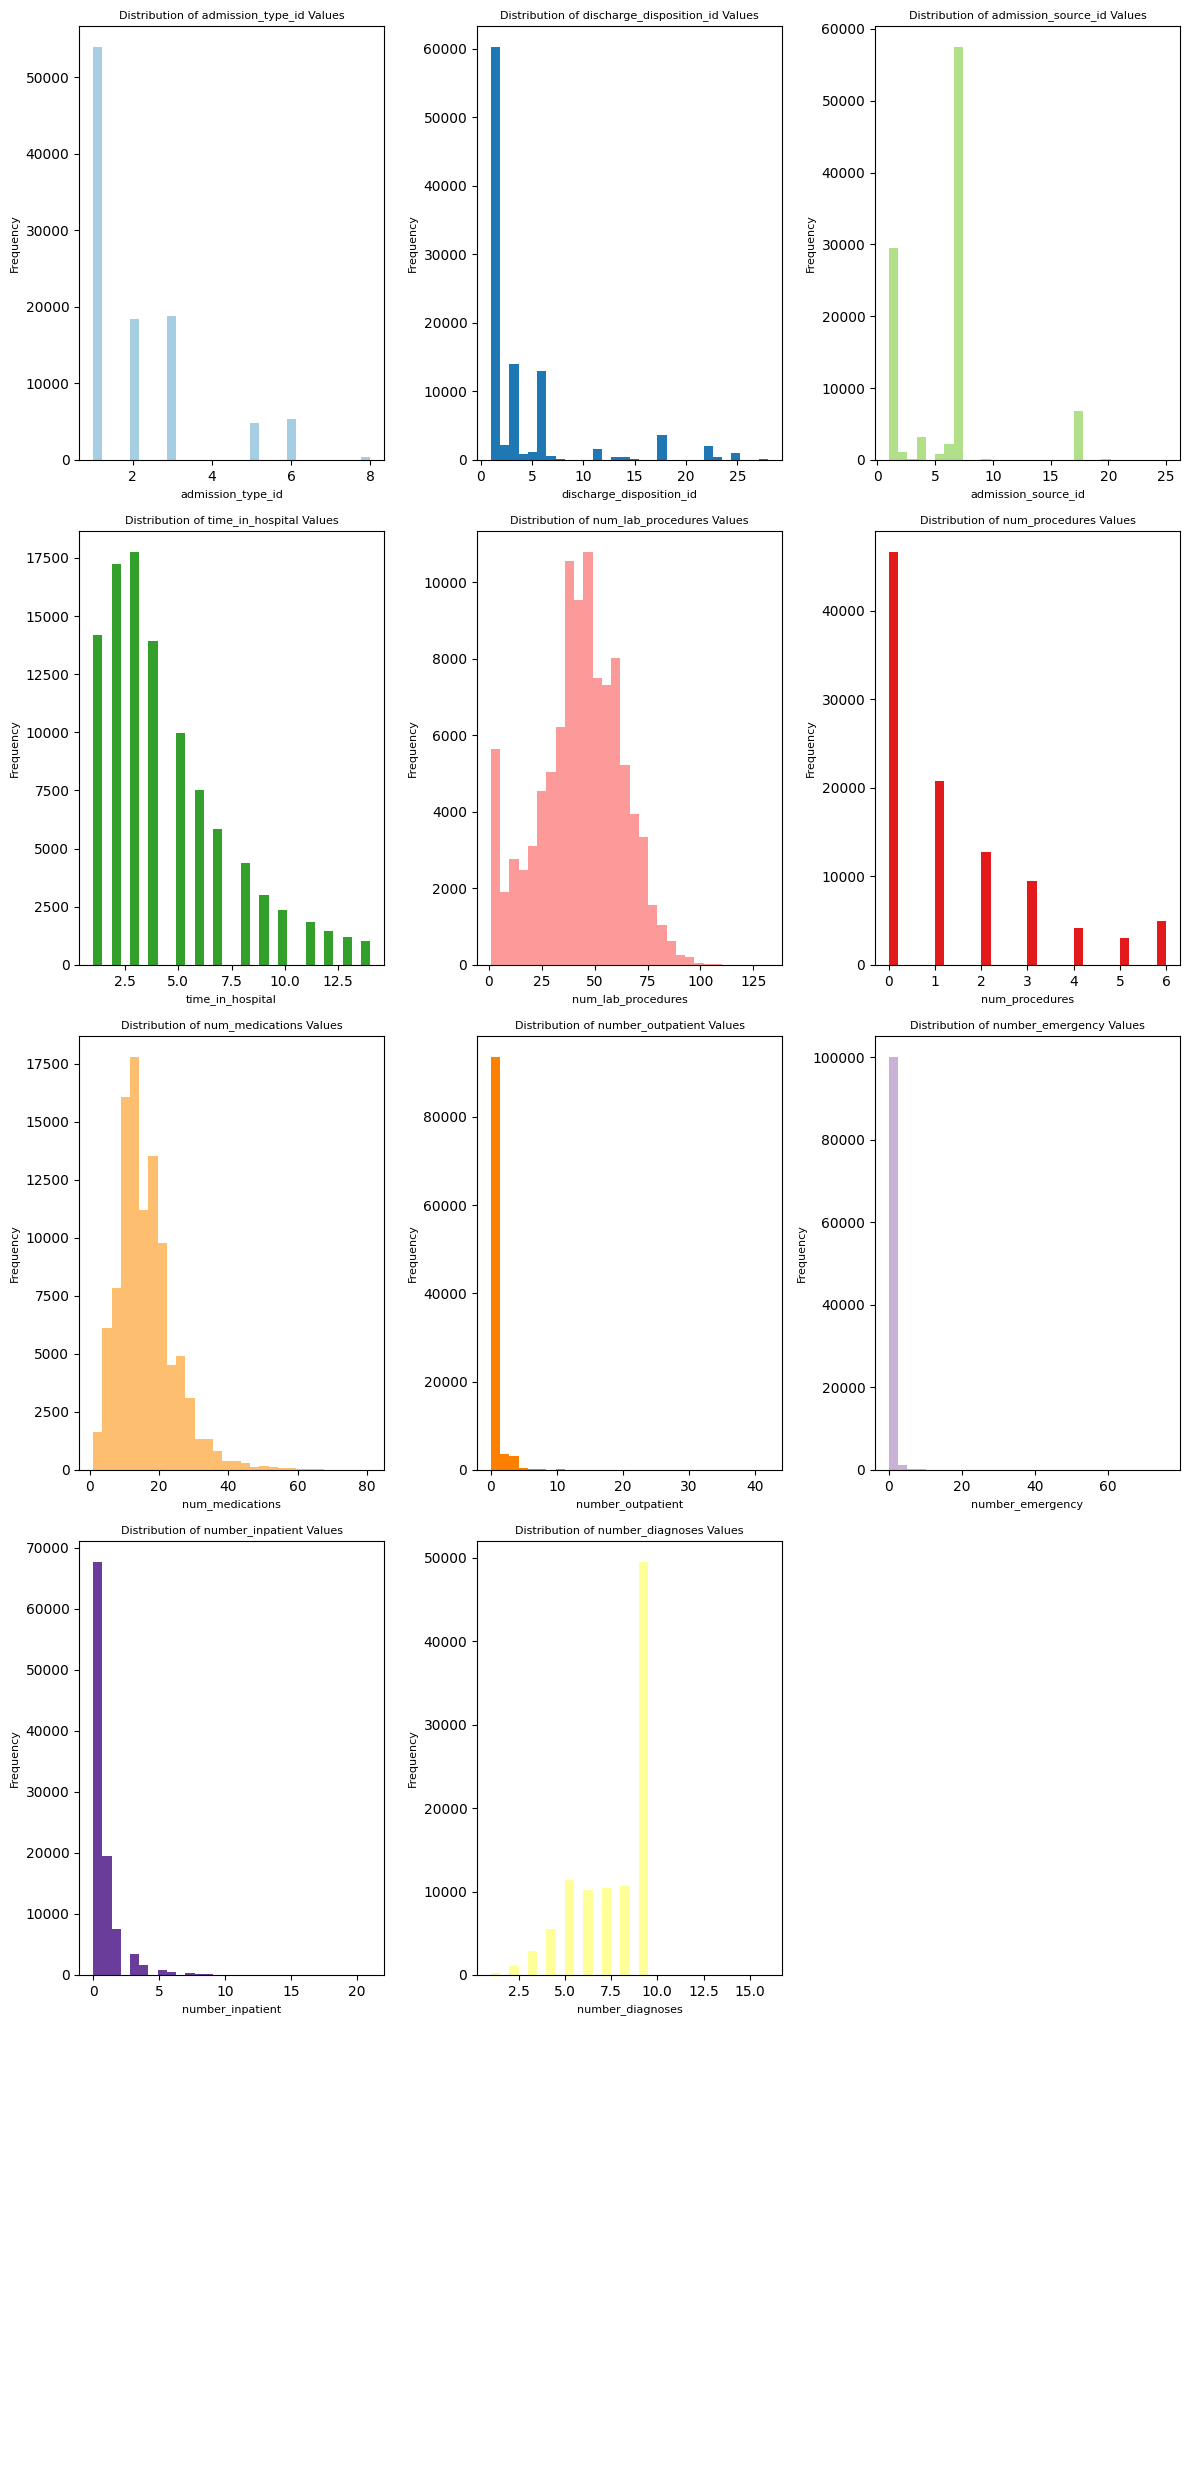

In [12]:
n_cols = len(int_columns)
n_rows = -(-n_cols // 3) 

fig, axes = plt.subplots(n_rows, 3, figsize=(12, 5 * n_rows))

axes = axes.ravel()

int_cols_to_show = [col for col in int_columns if col not in ['encounter_id', 'patient_nbr']]

for idx, col in enumerate(int_cols_to_show):
    column_data = df[col].dropna()  
    axes[idx].hist(column_data, bins=30, color=plt.cm.Paired.colors[idx % len(plt.cm.Paired.colors)])
    axes[idx].set_title(f'Distribution of {col} Values', fontsize=8)
    axes[idx].set_ylabel('Frequency', fontsize=8)
    axes[idx].set_xlabel(col, fontsize=8)

for j in range(idx+1, n_rows*3):
    axes[j].axis('off')

plt.tight_layout()  
plt.show()


Most of the columns are left skewed, num_lab_procedures is partly normally distributed, and number_diagnosis is right skewed.

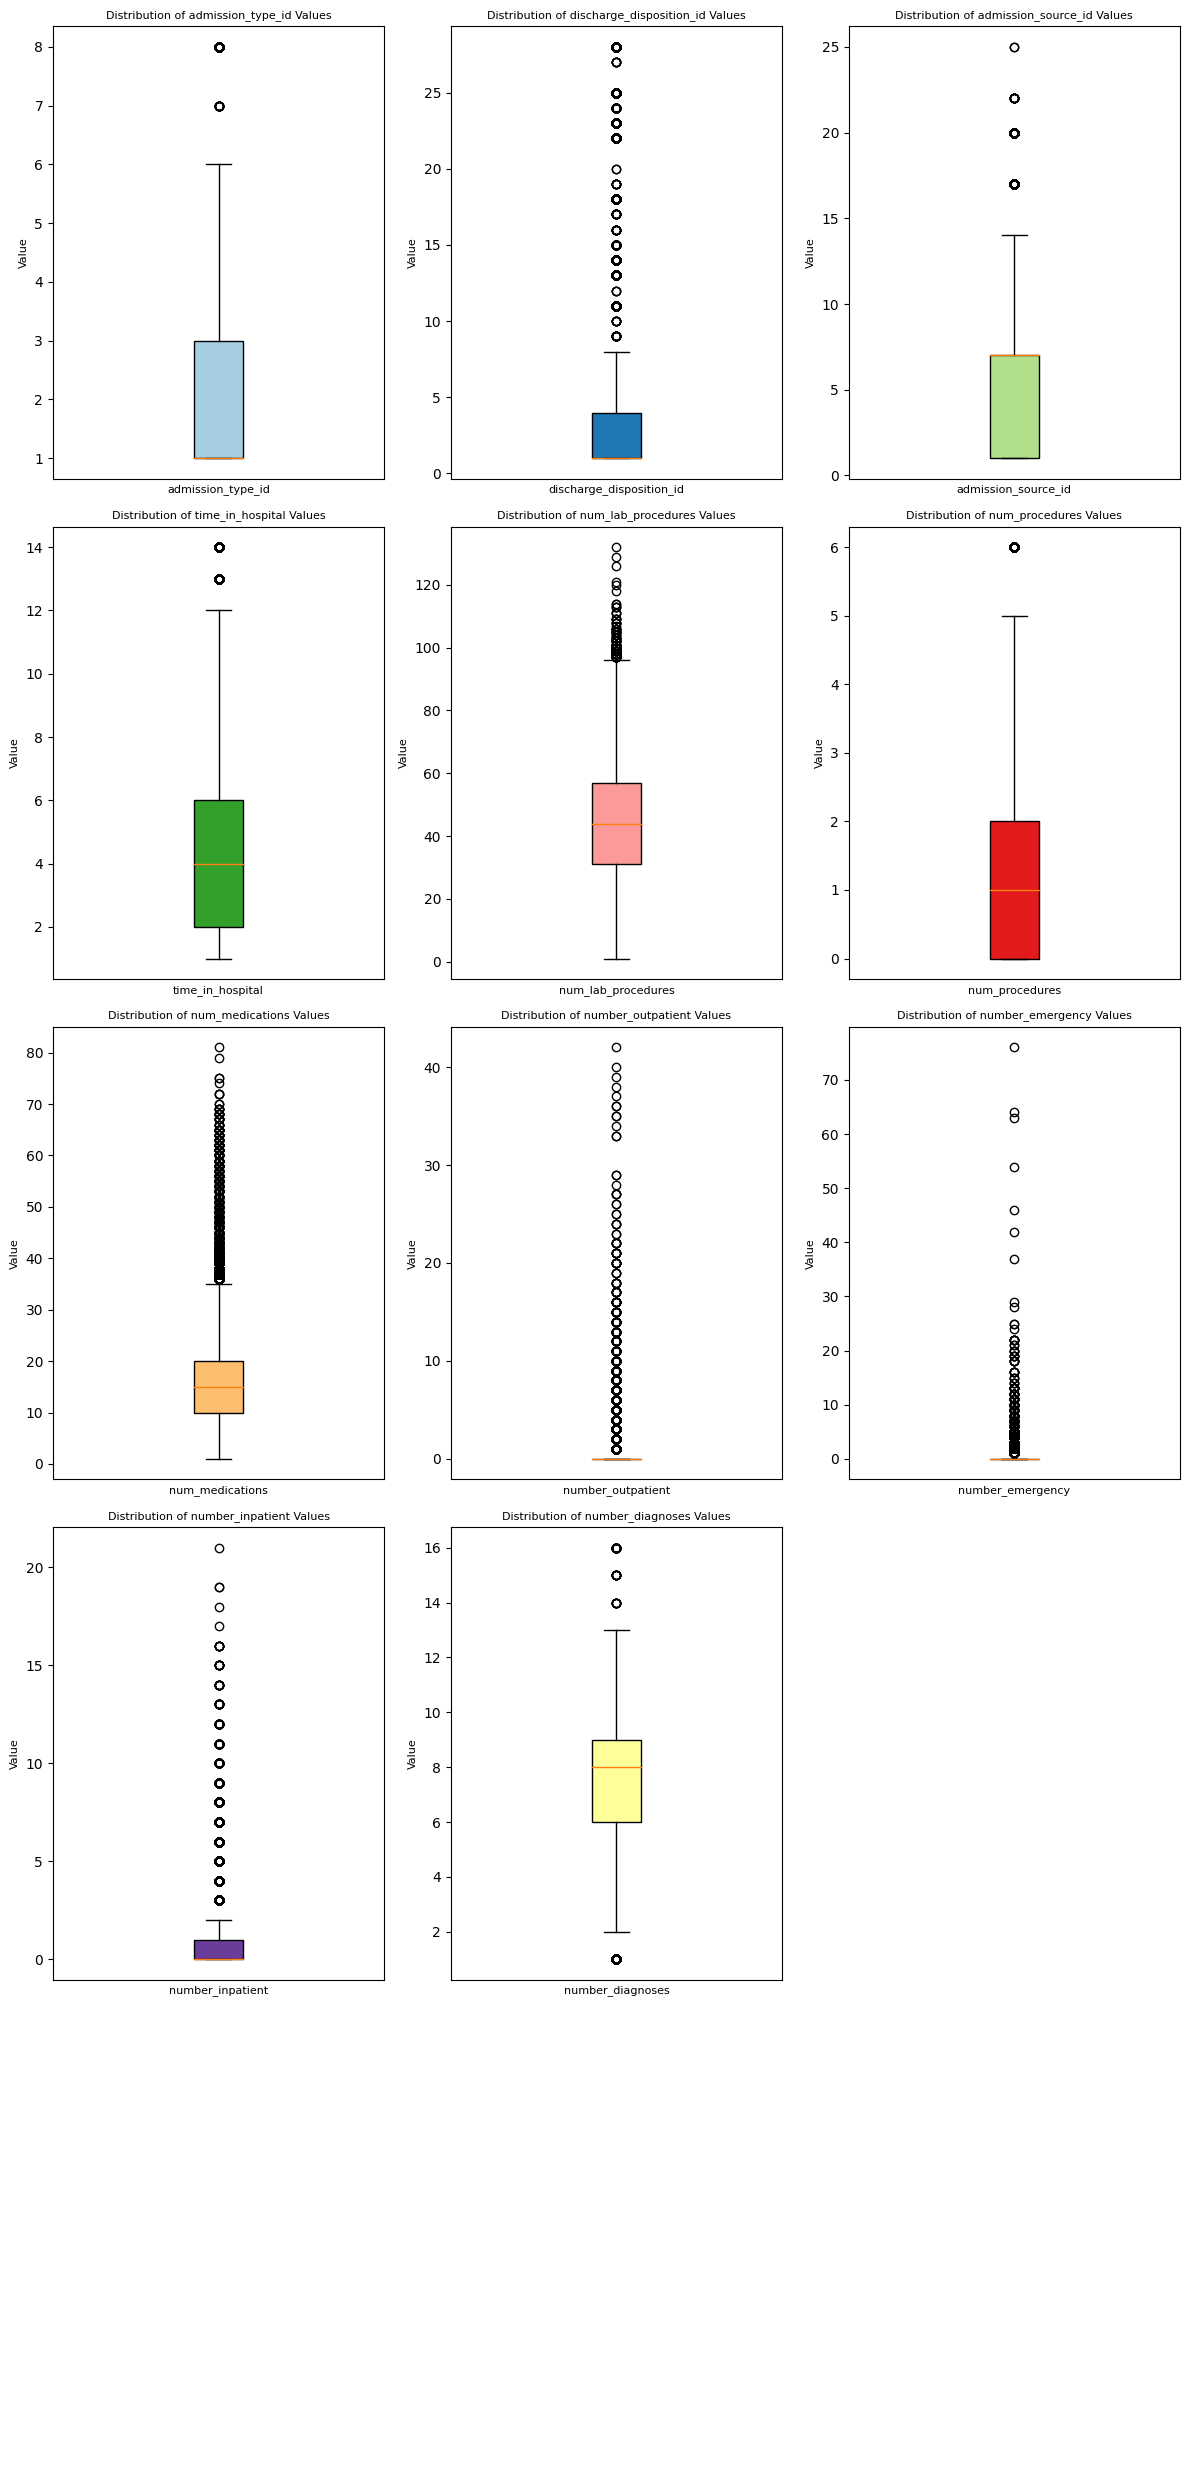

In [13]:
n_cols = len(int_columns)
n_rows = -(-n_cols // 3) 

fig, axes = plt.subplots(n_rows, 3, figsize=(12, 5 * n_rows))

axes = axes.ravel()
int_cols_to_show = [col for col in int_columns if col not in ['encounter_id', 'patient_nbr']]

for idx, col in enumerate(int_cols_to_show):
    column_data = df[col].dropna()  
    axes[idx].boxplot(column_data, patch_artist=True,
                      boxprops=dict(facecolor=plt.cm.Paired.colors[idx % len(plt.cm.Paired.colors)], color='black'))
    axes[idx].set_title(f'Distribution of {col} Values', fontsize=8)
    axes[idx].set_ylabel('Value', fontsize=8)
    axes[idx].set_xlabel(col, fontsize=8)
    axes[idx].set_xticks([])  

for j in range(idx+1, n_rows*3):
    axes[j].axis('off')

plt.tight_layout()  
plt.show()

No discernible outliers as far as I can see. Some columns have higher variance than others.
### Things to do:
1. Handle missing data and question marks.
2. Remove columns with only one value.
3. Convert diag_1, diag_2, and diag_3 to numeric.
4. Remove encounter_id and patient_nbr columns since they aren't relevant."

In [14]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [15]:
cols_with_single_value = df.columns[df.nunique() == 1].tolist()
cols_with_single_value

['examide', 'citoglipton']

In [16]:
df_copy = df.copy()

In [17]:
df_copy = df_copy.drop(['encounter_id', 'patient_nbr'], axis = 1)

In [18]:
df_copy.replace('?', pd.NA, inplace=True)
missing_percentage = (df_copy.isna().sum() / len(df)) * 100
data_summary = df_copy.describe(include='all').transpose()
data_summary['missing_percentage'] = missing_percentage

data_summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_percentage
race,99493,5,Caucasian,76099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.233555
gender,101766,3,Female,54708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
age,101766,10,[70-80),26068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
weight,3197,9,[75-100),1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.858479
admission_type_id,101766.0,NaN,NaN,NaN,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0,0.000000
discharge_disposition_id,101766.0,NaN,NaN,NaN,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0,0.000000
admission_source_id,101766.0,NaN,NaN,NaN,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0,0.000000
time_in_hospital,101766.0,NaN,NaN,NaN,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0,0.000000
payer_code,61510,17,MC,32439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.557416
medical_specialty,51817,72,InternalMedicine,14635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.082208


In [19]:
data_summary[data_summary['missing_percentage']>0]

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_percentage
race,99493,5,Caucasian,76099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.233555
weight,3197,9,[75-100),1336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.858479
payer_code,61510,17,MC,32439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.557416
medical_specialty,51817,72,InternalMedicine,14635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.082208
diag_1,101745,716,428,6862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.020636
diag_2,101408,748,276,6752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351787
diag_3,100343,789,250,11555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.398306
max_glu_serum,5346,3,Norm,2597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.746772
A1Cresult,17018,3,>8,8216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.277322


### Handling missing data:
* Cols with less than 5% missing will be imputed with mode or median.
* Cols with a higher percentage of missing data will be imputed with 'unknown' since they contain valuable data that is relevant to the case.

In [20]:
cols_with_missing_values = data_summary[data_summary['missing_percentage']>0].index.to_list()
cols_with_missing_values

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult']

In [21]:
cols_to_impute_with_median = ['diag_1','diag_2','diag_3']
cols_to_impute_with_mode = ['race']
cols_to_impute_with_unknown = data_summary[data_summary['missing_percentage']>5].index.to_list()

### Data preprocessing

In [22]:
cols_to_remove = cols_with_single_value + ['encounter_id', 'patient_nbr']
cols_to_remove

['examide', 'citoglipton', 'encounter_id', 'patient_nbr']

In [23]:
def primary_preprocess(df, cols_to_remove):
    df = df.replace('?', pd.NA)
    cols_to_drop = [col for col in cols_to_remove if col in df.columns ]
    df = df.drop(columns=cols_to_drop)          
    return df

In [24]:
df = primary_preprocess(df,cols_to_remove)
df.shape

(101766, 46)

In [25]:
train, test = train_test_split(df, test_size=0.25, random_state=42, stratify=df['readmitted'])

In [26]:
train.columns

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [27]:
for col in cols_to_impute_with_median:
    train[col] = pd.to_numeric(train[col], errors='coerce')

median_dict = train[cols_to_impute_with_median].median().to_dict()
median_dict

{'diag_1': 438.0, 'diag_2': 425.0, 'diag_3': 403.0}

In [28]:
mode_dict = train[cols_to_impute_with_mode].mode().iloc[0].to_dict()
mode_dict

{'race': 'Caucasian'}

In [29]:
cols_to_impute_with_unknown = ['weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']

In [30]:
impute_dict = {
    'median': median_dict,
    'mode': mode_dict,
    'cols_to_impute_with_mode': cols_to_impute_with_mode,
    'cols_to_impute_with_median': cols_to_impute_with_median,
    'cols_to_impute_with_unknown': cols_to_impute_with_unknown
}

In [31]:
def impute_from_dict(df, impute_dict):

    for col in impute_dict['cols_to_impute_with_mode']:
        if col in df.columns and col in impute_dict['mode']:
            df[col].fillna(impute_dict['mode'][col], inplace=True)

    for col in impute_dict['cols_to_impute_with_median']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if col in df.columns and col in impute_dict['median']:
            df[col].fillna(impute_dict['median'][col], inplace=True)

    for col in impute_dict['cols_to_impute_with_unknown']:
        df[col] = df[col].fillna('unknown')
    
    return df

In [32]:
imputed_df = impute_from_dict(train, impute_dict)
display(imputed_df.shape)
display(imputed_df.columns[imputed_df.isna().any()].tolist())

(76324, 46)

[]

In [33]:
categorical_columns = [col for col in object_columns if col not in cols_to_impute_with_median]
categorical_columns = [col for col in categorical_columns if col not in cols_to_remove]
categorical_columns = categorical_columns[:-1]
numerical_columns = int_columns + cols_to_impute_with_median
numerical_columns = [col for col in numerical_columns if col not in cols_to_remove]

In [34]:
impute_dict['categorical_columns'] = categorical_columns
impute_dict['numerical_columns'] = numerical_columns

In [35]:
def generate_encoders(df, categorical_columns):
    encoders = {}
    for col in categorical_columns:
        encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
        encoder.fit(df[[col]])
        encoders[col] = encoder
    with open("encoders.pkl", 'wb') as f:
        pickle.dump(encoders, f)
    return encoders

In [36]:
def generate_scalers(df, numerical_columns):
    scalers = {}
    for col in numerical_columns:
        scaler = MinMaxScaler()
        scaler.fit(df[[col]])
        scalers[col] = scaler
    with open("scalers.pkl", 'wb') as f:
        pickle.dump(scalers, f)
    return scalers

In [37]:
encoders = generate_encoders(imputed_df,categorical_columns)

In [38]:
scalers = generate_scalers(imputed_df,numerical_columns)

In [39]:
def transform_categorical_data(df, encoders, categorical_columns):
    df_concat = pd.DataFrame()
    for col in categorical_columns:
        encoded_data = encoders[col].transform(df[[col]]).toarray()
        column_names = encoders[col].get_feature_names_out([col])
        encoded_df = pd.DataFrame(encoded_data, columns=column_names)
        df_concat = pd.concat([df_concat, encoded_df], axis=1)
    return df_concat

In [40]:
def transform_numerical_data(df, scalers, numerical_columns):
    df_normalized = pd.DataFrame()
    for col in numerical_columns:
        scaled_data = scalers[col].transform(df[[col]])
        scaled_df = pd.DataFrame(scaled_data, columns=[col])
        df_normalized = pd.concat([df_normalized, scaled_df], axis=1)
    return df_normalized

In [41]:
df_scaled = transform_numerical_data(imputed_df, scalers, numerical_columns)
df_scaled.shape

(76324, 14)

In [42]:
df_encoded = transform_categorical_data(imputed_df, encoders, categorical_columns)
df_encoded.shape

(76324, 163)

In [43]:
X_train = pd.concat([df_scaled,df_encoded], axis = 1)
y_train = imputed_df['readmitted'].map({'NO':0, '>30':1, '<30':2})

In [44]:
X_train.shape

(76324, 177)

In [45]:
y_train.shape

(76324,)

### Feature selection

In [46]:
fwiz = FeatureWiz()

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        


In [47]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.9 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Multi_Classification problem ####
    Loaded train data. Shape = (76324, 178)
    Some column names had special characters which were removed...
#### Single_Label Multi_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Multi_Classification problem ####
    loading a random sample 

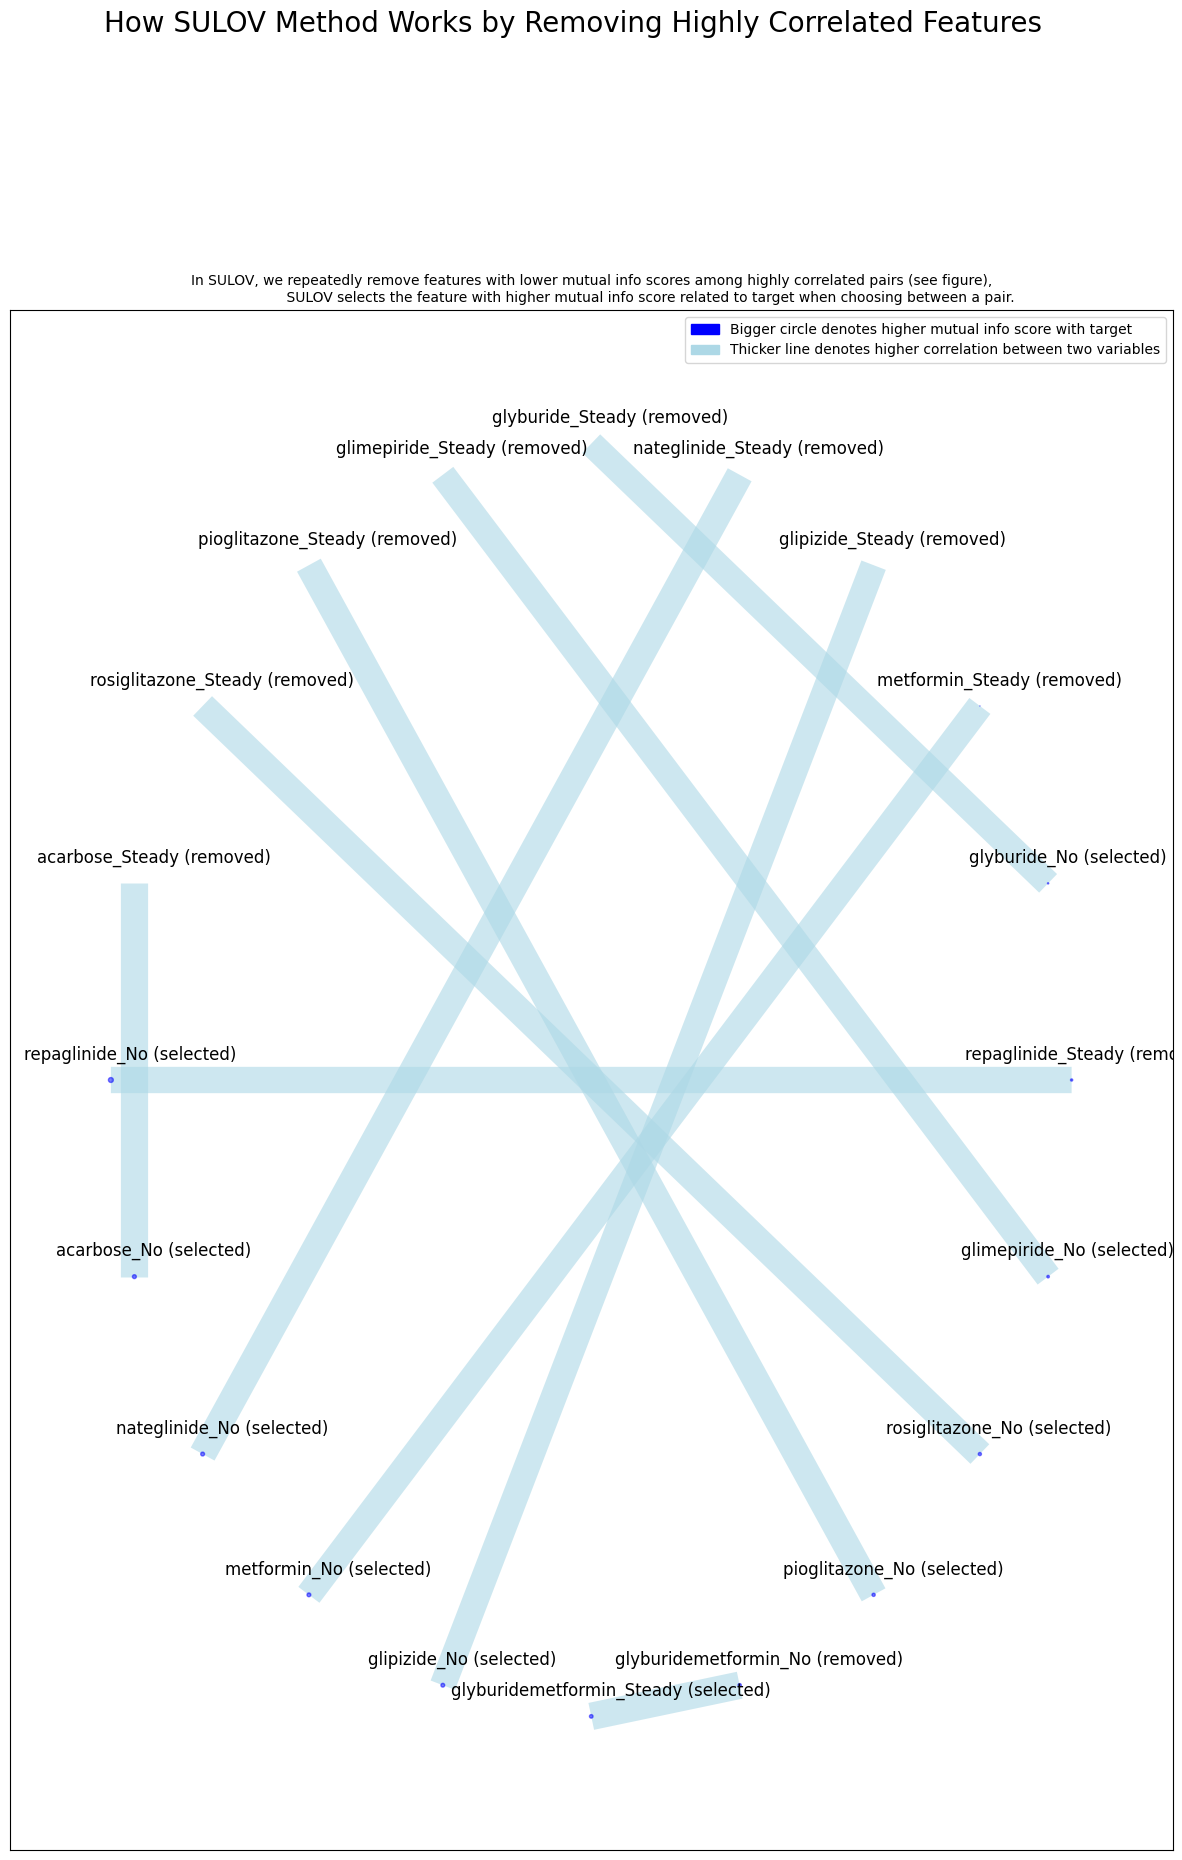

Time taken for SULOV method = 11 seconds
    Adding 0 categorical variables to reduced numeric variables  of 142
Finally 142 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 30 features per iteration...
    XGBoost version using 1.7.6 as tree method: hist
    Number of booster rounds = 100
        Selected: ['number_inpatient', 'discharge_disposition_id', 'diag_1', 'diag_2', 'num_lab_procedures', 'diag_3', 'num_medications', 'number_diagnoses', 'admission_source_id', 'time_in_hospital', 'number_outpatient', 'number_emergency', 'num_procedures', 'admission_type_id', 'payer_code_unknown', 'diabetesMed_Yes', 'age_8090', 'race_Caucasian', 'medical_sp

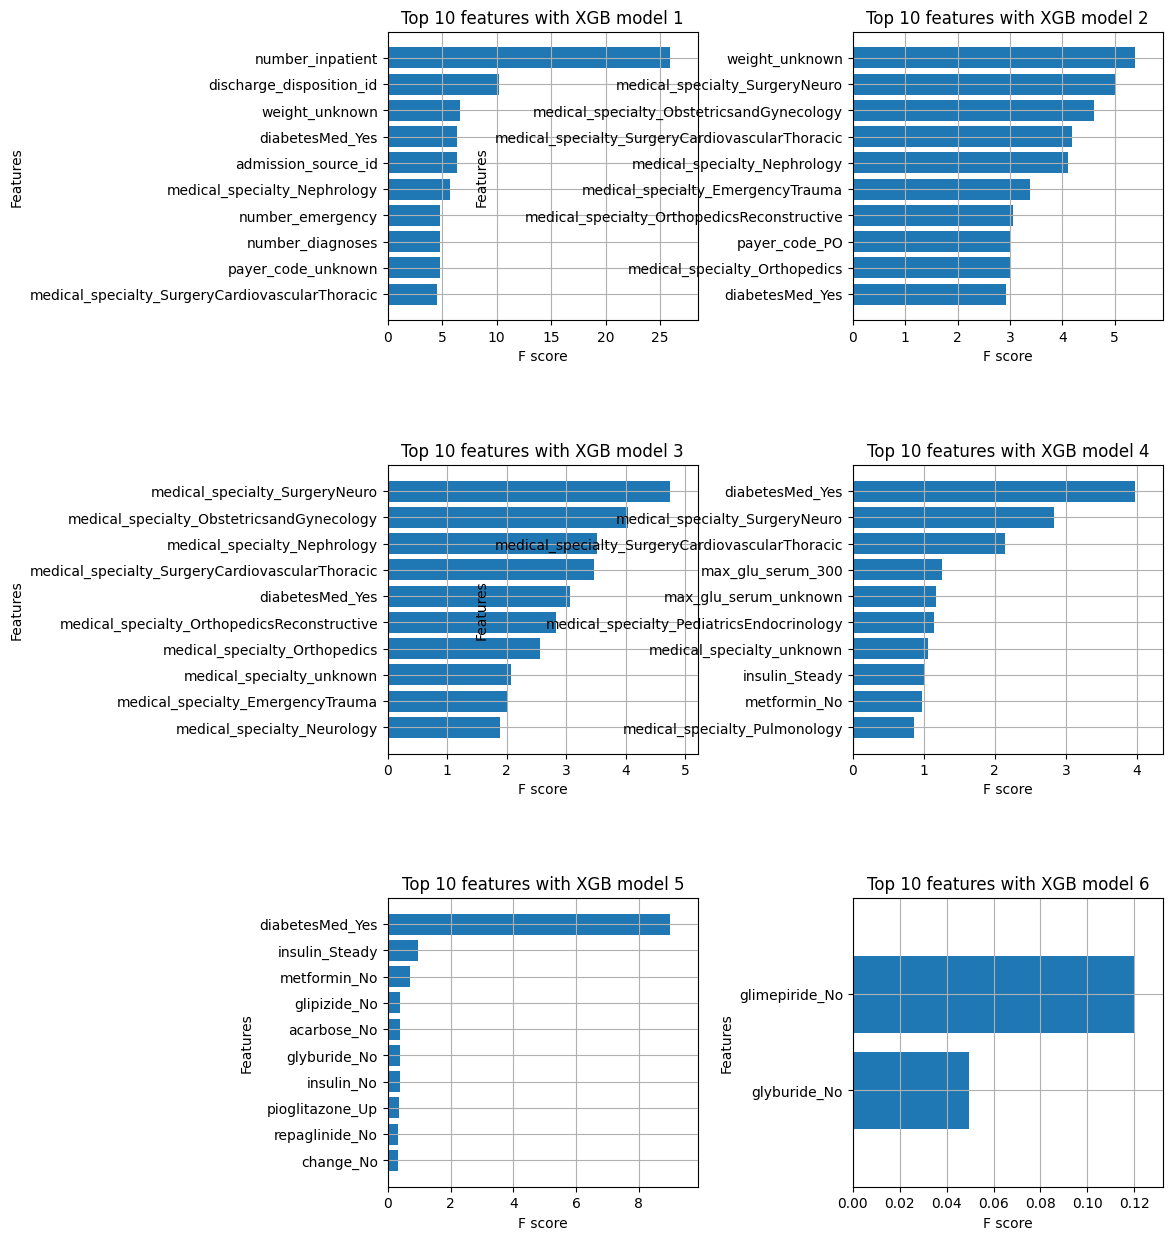

    Completed XGBoost feature selection in 3 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 75 important features. Too many to print...
Total Time taken for featurewiz selection = 131 seconds
Output contains a list of 75 important features and a train dataframe
    Time taken to create entire pipeline = 133 second(s)


In [48]:
X_train_selected = fwiz.fit_transform(X_train, y_train)

In [49]:
relevant_features = fwiz.features

In [50]:
len(fwiz.features)

75

In [51]:
impute_dict['relevant_features'] = relevant_features
impute_dict['cols_to_remove'] = cols_to_remove

In [52]:
with open('impute_dict.json', 'w') as f:
    json.dump(impute_dict, f)

In [53]:
def transform_data(df):
    for col in cols_to_impute_with_median:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df_imputed = impute_from_dict(df, impute_dict)
    df_scaled = transform_numerical_data(df_imputed, scalers, numerical_columns)
    df_encoded = transform_categorical_data(df_imputed, encoders, categorical_columns)
    X = pd.concat([df_scaled,df_encoded], axis = 1)
    y = df['readmitted'].map({'NO':0, '>30':1, '<30':2})
    X_selected = X[relevant_features]
    return X,X_selected,y


In [54]:
X_test,X_test_selected,y_test = transform_data(test)

In [55]:
X_test_selected.shape

(25442, 75)

In [56]:
X_train_selected.shape

(76324, 75)

In [57]:
X_test = X_test.reset_index(drop=True)
X_test_selected = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [58]:
train_all_features = pd.concat([X_train,y_train], axis = 1)
train_selected_features = pd.concat([X_train_selected,y_train], axis = 1)
test_all_features = pd.concat([X_test,y_test], axis = 1)
test_selected_features = pd.concat([X_test_selected,y_test], axis = 1)

In [59]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [60]:
train_all_features.to_csv('preprocessed_data/train_all_features.csv', index = False)
train_selected_features.to_csv('preprocessed_data/train_selected_features.csv', index = False)
test_all_features.to_csv('preprocessed_data/test_all_features.csv', index = False)
test_selected_features.to_csv('preprocessed_data/test_selected_features.csv', index = False)

In [61]:
test.to_csv('preprocessed_data/test_raw.csv', index = False)

In [62]:
test.head(20).to_csv('preprocessed_data/test_raw_sample.csv', index = False)

### Creating downsampled data

In [63]:
min_class_size = train_all_features['readmitted'].value_counts().min()     
downsampled_df_all_features = train_all_features.groupby('readmitted').apply(lambda group: group.sample(min_class_size)).reset_index(drop=True)
downsampled_df_selected_features = train_selected_features.groupby('readmitted').apply(lambda group: group.sample(min_class_size)).reset_index(drop=True)

In [64]:
downsampled_df_all_features.shape

(25554, 178)

In [65]:
downsampled_df_all_features.to_csv('preprocessed_data/downsampled_train_all_features.csv', index = False)
downsampled_df_selected_features.to_csv('preprocessed_data/downsampled_train_selected_features.csv', index = False)